<a href="https://colab.research.google.com/github/nikitachinchwade/bigdata-AI/blob/main/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files,drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import torch,datasets,transforms,models
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import cv2
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Importing Labelled Train Set, Unlabeleld Test Set and Image Set


In [ ]:
#details = "/content/drive/MyDrive/archive (1)/Medical mask/Medical mask/Medical Mask/annotations"
#images= "/content/drive/MyDrive/archive (1)/Medical mask/Medical mask/Medical Mask/images"
df_train = pd.read_csv("/content/drive/MyDrive/archive (1)/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/archive (1)/submission.csv")
images_path = "/content/drive/MyDrive/archive (1)/Medical mask/Medical mask/Medical Mask/images"

In [ ]:
print(df_train['classname'].value_counts()) ## Number of Labels present in Dataset

face_with_mask              4180
mask_surgical               2430
mask_colorful               1876
face_no_mask                1569
face_other_covering         1372
eyeglasses                   914
hat                          823
sunglasses                   358
hair_net                     287
scarf_bandana                260
goggles                      192
helmet                       187
hijab_niqab                  173
face_shield                  160
hood                         159
face_with_mask_incorrect     150
balaclava_ski_mask           134
turban                        94
gas_mask                      55
other                         39
Name: classname, dtype: int64


In [ ]:
mask = ['face_with_mask','face_no_mask', 'face_with_mask_incorrect']
masks_train= df_train[df_train['classname'].isin(mask)]
masks_train.sort_values('name',axis=0,inplace=True)
#masks_train.head()
masks_train['classname'] = np.where((masks_train.classname == 'face_with_mask_incorrect'),'face_no_mask',masks_train.classname)
masks_train['Labels'] = masks_train.classname.apply(lambda x: 1 if x=='face_with_mask' else 0)
masks_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,name,x1,x2,y1,y2,classname,Labels
13381,1801.jpg,451,186,895,697,face_no_mask,0
3463,1802.jpg,110,71,273,272,face_with_mask,1
14835,1803.jpg,126,75,303,333,face_with_mask,1
5867,1804.jpg,112,113,262,307,face_with_mask,1
6194,1805.jpg,728,180,853,336,face_with_mask,1


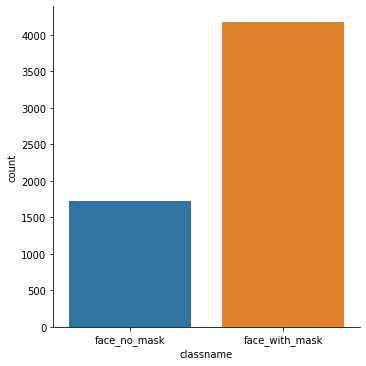

In [ ]:
ax = sns.catplot(x='classname',kind='count',data=masks_train,orient="h",height=5)
## Unbalanced classes

In [ ]:
masks_train.rename(columns = {'x2' : 'y1', 'y1' : 'x2'}, inplace = True)

len(masks_train)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


5899

In [ ]:
## visualise images
def draw_box(image_name):
    img=plt.imread(os.path.join(images_path,image_name))
    temp=masks_train[masks_train.name==image_name]
    print(temp)
    fig,ax=plt.subplots(1)
    fig.set_size_inches(10,5)
    ax.imshow(img)
    ax.axis('off')
    edgecolor={"face_no_mask":"r","face_with_mask":"b"}
    for i in range(len(temp)):
        a,b,c,d=temp.values[i][1:5]
        patch=patches.Rectangle((a,b),c-a,d-b,linewidth=2, 
                                edgecolor=edgecolor[temp.values[i][5:6][0]],facecolor="none",)
        ax.text(a, b, temp.values[i][5:6][0], style='italic',bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 10})
        ax.add_patch(patch)

           name    x1   y1    x2   y2       classname  Labels
14091  5031.jpg   937   57  1092  249  face_with_mask       1
14092  5031.jpg  1392  186  1450  284    face_no_mask       0


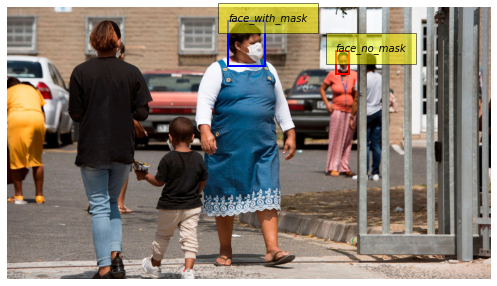

In [ ]:
draw_box(random.choice(masks_train.name.values))

## Preparing Training Data


In [ ]:
from skimage import io
from torch.utils.data import Dataset, DataLoader
class MaskAndNoMask(Dataset): 
    def __init__(self,dataframe,image,transform=None):
        self.df=dataframe
        self.image=image
        self.transform=transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        img_path=os.path.join(self.image,self.df.iloc[index,0])
        new_img=Image.open(img_path).crop((self.df.iloc[index,1:5]))
        label=torch.tensor(int(self.df.iloc[index,6:7]))
    
        if self.transform:
            image=self.transform(new_img)
            return(image,label)

In [ ]:
from torch.utils.data import random_split
from torchvision import transforms, utils

In [ ]:
my_transform=transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor()])


dataset = MaskAndNoMask(masks_train, images_path, transform = my_transform)



In [ ]:
train_size=int(len(dataset)*0.8)
val_size = len(dataset)-train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size=100

train_loader=DataLoader(train_dataset, shuffle=True,batch_size=batch_size)
val_loader = DataLoader(val_dataset,shuffle=True,batch_size=batch_size)

Images after cropping only faces


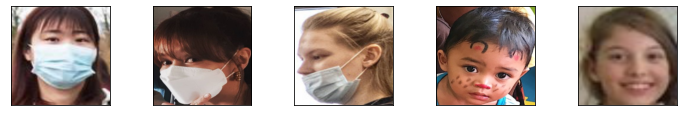

In [ ]:
dataiter=iter(train_loader)
images,labels=dataiter.next()
images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(5):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(images[idx],(1,2,0)))

## CNN Network


In [ ]:
class myCNN(nn.Module):

  def __init__(self):
    ## defin/add/conv layer
    #pooling layer
    #define anotehr conv layer 
    # def fully connected FFN

    super().__init__()
    self.conv1=nn.Conv2d(3,100,3)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(100,64,3)
    #lself.conv3=nn.Conv2d(64,64,3)
    self.fc1 = nn.Linear(64*54*54,50)
    #self.fc2 = nn.Linear(120,50)
    self.fc2 = nn.Linear(50,2)
    self.do1= nn.Dropout(0.5)

  def forward(self,x):
    ##x--> conv-->pooling-->conv2-->relu-->poolimg --> fully connceted
    x = self.pool(F.relu(self.conv1(x)))
    x= self.pool(F.relu(self.conv2(x)))
    #x= self.pool(F.relu(self.conv3(x)))
    x=self.do1(x)
    x=x.view(-1,self.num_flat_features(x))
    x=  F.relu(self.fc1(x))
    x=self.do1(x)
    #x=  F.relu(self.fc2(x))
    x= F.log_softmax(self.fc2(x),dim=1)

    return x
  def num_flat_features(self, x):
    size= x.size()[1:]
    num_features=1
    for s in size:
      num_features *= s

    return num_features  
cNNmodel= myCNN()
if torch.cuda.is_available():
  cNNmodel = myCNN().to(device)
print(cNNmodel)    

NameError: ignored

## Training Function


In [ ]:
def trainModel(model,epochs,train_loader, val_loader, optimizer,criterion ):
  
  #optimizer=optim.SGD(resnet.parameters(),lr=learning_rate)
  #print (22)
  train_losses = []
  valid_losses = []
  for epoch in range(1, epochs + 1):
      # keep-track-of-training-and-validation-loss
      train_loss = 0.0
      valid_loss = 0.0
      
      # training-the-model
      model.train()
      for data, target in train_loader:
          # move-tensors-to-GPU 
          data = data.to(device)
          target = target.type(torch.LongTensor).to(device)
          
          # clear-the-gradients-of-all-optimized-variables
          optimizer.zero_grad()
          # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
          output = model(data)
          # calculate-the-batch-loss
          loss = criterion(output, target)
          # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
          loss.backward()
          # perform-a-ingle-optimization-step (parameter-update)
          optimizer.step()
          # update-training-loss
          train_loss += loss.item() * data.size(0)
          
      # validate-the-model
      model.eval()
      correct = 0
      total = 0
      for data, target in val_loader:
          
          data = data.to(device,dtype=torch.float)
          target = target.to(device)
          
          outputs = model(data)
          _, predicted = torch.max(outputs.data, 1)
          loss = criterion(outputs, target)
          
          total += target.size(0)
          correct += (predicted == target).sum().item()
          
          # update-average-validation-loss 
          valid_loss += loss.item() * data.size(0)
      
      # calculate-average-losses
      train_loss = train_loss/len(train_loader.sampler)
      valid_loss = valid_loss/len(val_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
          
      # print-training/validation-statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      print('Test Accuracy of the model: {} %'.format(100 * correct / total))

[link text](https://)## CNN Network Training


In [ ]:
epochs=10
learning_rate=1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cNNmodel.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
trainModel(model= cNNmodel, epochs=epochs,train_loader = train_loader, val_loader=val_loader, optimizer=optimizer,criterion=criterion)

Epoch: 1 	Training Loss: 0.675803 	Validation Loss: 0.365772
Test Accuracy of the model: 84.15254237288136 %
Epoch: 2 	Training Loss: 0.384002 	Validation Loss: 0.315305
Test Accuracy of the model: 86.94915254237289 %
Epoch: 3 	Training Loss: 0.371442 	Validation Loss: 0.311041
Test Accuracy of the model: 87.28813559322033 %
Epoch: 4 	Training Loss: 0.336070 	Validation Loss: 0.279557
Test Accuracy of the model: 88.13559322033899 %
Epoch: 5 	Training Loss: 0.332187 	Validation Loss: 0.281088
Test Accuracy of the model: 88.98305084745763 %
Epoch: 6 	Training Loss: 0.321956 	Validation Loss: 0.284439
Test Accuracy of the model: 88.38983050847457 %
Epoch: 7 	Training Loss: 0.297156 	Validation Loss: 0.267354
Test Accuracy of the model: 88.89830508474576 %
Epoch: 8 	Training Loss: 0.293815 	Validation Loss: 0.274562
Test Accuracy of the model: 89.15254237288136 %
Epoch: 9 	Training Loss: 0.297351 	Validation Loss: 0.293684
Test Accuracy of the model: 87.62711864406779 %
Epoch: 10 	Training

In [ ]:
torch.save(cNNmodel,open("CNN_face_mask_detect","wb"))
model1=torch.load(open("./CNN_face_mask_detect","rb"))

In [ ]:
model1

myCNN(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=186624, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
  (do1): Dropout(p=0.5, inplace=False)
)

## Pre Trained ResNet Model


In [ ]:
resnet = models.resnet34(pretrained=True)

In [ ]:
for param in resnet.parameters():
    param.requires_grad=True

In [ ]:
import torch.nn as nn
n_inputs=resnet.fc.in_features
last_layer=nn.Linear(n_inputs,2)
resnet.fc.out_features=last_layer

if torch.cuda.is_available():
    resnet.cuda()

print(resnet.fc.out_features)

Linear(in_features=512, out_features=2, bias=True)


In [ ]:
criterion=nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer=optim.SGD(resnet.parameters(),lr=learning_rate)
epochs =10

In [ ]:
trainModel(model= resnet, epochs=epochs,train_loader = train_loader, val_loader=val_loader, optimizer=optimizer,criterion=criterion)

Epoch: 1 	Training Loss: 4.038103 	Validation Loss: 1.238616
Test Accuracy of the model: 81.01694915254237 %
Epoch: 2 	Training Loss: 0.641007 	Validation Loss: 0.467931
Test Accuracy of the model: 91.10169491525424 %
Epoch: 3 	Training Loss: 0.321674 	Validation Loss: 0.303568
Test Accuracy of the model: 92.71186440677967 %
Epoch: 4 	Training Loss: 0.228293 	Validation Loss: 0.254016
Test Accuracy of the model: 93.38983050847457 %
Epoch: 5 	Training Loss: 0.187921 	Validation Loss: 0.226882
Test Accuracy of the model: 93.47457627118644 %
Epoch: 6 	Training Loss: 0.155896 	Validation Loss: 0.211811
Test Accuracy of the model: 94.0677966101695 %
Epoch: 7 	Training Loss: 0.131035 	Validation Loss: 0.193673
Test Accuracy of the model: 94.66101694915254 %
Epoch: 8 	Training Loss: 0.117637 	Validation Loss: 0.192248
Test Accuracy of the model: 94.32203389830508 %
Epoch: 9 	Training Loss: 0.105128 	Validation Loss: 0.177362
Test Accuracy of the model: 94.7457627118644 %
Epoch: 10 	Training L

In [ ]:
#%%time
# keeping-track-of-losses 


In [ ]:
torch.save(resnet,open("resnet_face_mask_detect","wb"))
modelRes=torch.load(open("./resnet_face_mask_detect","rb"))

In [ ]:
test_list = df_test['name']
test_list = df_test["name"].unique()
test_list[:10]

array(['1800.jpg', '1799.jpg', '1797.jpg', '1796.jpg', '1795.jpg',
       '1794.jpg', '1793.jpg', '1792.jpeg', '1791.jpg', '1790.jpg'],
      dtype=object)

In [ ]:
pip install facenet_pytorch

In [ ]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN()
model=modelRes.eval()


## Testing out model on unlabelled data


In [ ]:

def testImages(imagePath):
  img=Image.open(imagePath)
  boxes, _ = mtcnn.detect(img)
  predictions=[]
  for i in boxes:
      image_crr=img.crop(i)
      image1=my_transform(image_crr).unsqueeze(0)
      output=model(image1.cuda())
      _,pred=torch.max(output,1)
      predicted=pred.numpy() if not torch.cuda.is_available() else pred.cpu().numpy()
      predictions.append(predicted[0])
  #self.boxes=boxes
  #self.predictions=predictions
        
  img=plt.imread(imagePath)
  fig,ax=plt.subplots(1)
  fig.set_size_inches(10,5)
  ax.imshow(img)
  ax.axis('off')
  configuration=["face_no_mask", "face_with_mask"]
  color={"face_no_mask":"r","face_with_mask":"b"}
  for i,j in zip(boxes,predictions):
      a,b,c,d=i
      patch=patches.Rectangle((a,b),c-a,d-b,linewidth=2, 
                              edgecolor=color[configuration[j]],facecolor="none",)
      ax.text(a, b, configuration[j],
              style='italic',bbox={'facecolor': color[configuration[j]], 'alpha': 0.4, 'pad': 10})
      ax.add_patch(patch)

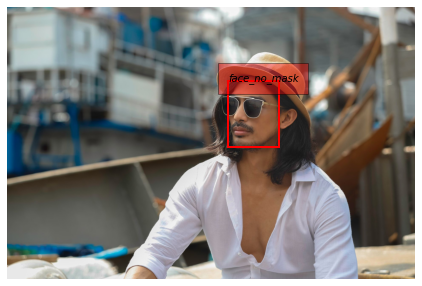

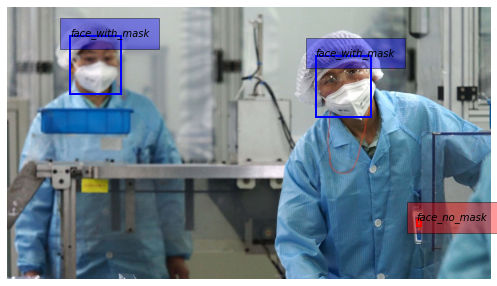

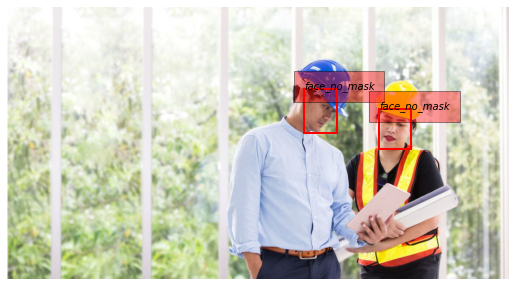

In [ ]:
test_images = ['0046.jpg','0039.jpg','0132.jpg']
for f in test_images:
  filepath=os.path.join(images_path,f)
  testImages(filepath)